# Dynamic Graph Embeddings for Real-Time Anomaly Detection in Network Traffic

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.nn import DySATConv

### Data Acquisition

#### Load the KDD Cup 1999 dataset

In [3]:
gzipped_data = "data/kddcup.data_10_percent.gz"

df = pd.read_csv(gzipped_data, compression='gzip')
df.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


### Data Preprocessing

#### Data Cleaning

In [4]:
df.drop_duplicates()
df.dropna()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [5]:
columns_to_keep = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'label'
]
data = df[columns_to_keep]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


#### Encode categorical variables using one-hot encoding

In [6]:
categorical_columns = ['protocol_type', 'service', 'flag']
encoder = LabelEncoder()

data_copy = data.copy()

for col in categorical_columns:
    data_copy[col] = encoder.fit_transform(data_copy[col])


#### Normalize or scale numeric features

In [7]:
numerical_columns = [
    'duration',
    'src_bytes',
    'dst_bytes',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
]

# Create a StandardScaler instance
scaler = StandardScaler()

# Normalize all relevant numerical columns
data_copy[numerical_columns] = scaler.fit_transform(data[numerical_columns])

#### Encode labels as binary (1 for attacks, 0 for normal)

In [8]:
data_copy['target'] = (data['label'] != 'normal').astype(int)

###  Data Splitting

In [9]:
X = data_copy.drop('label', axis=1)
y = data_copy['label']

#### Split the dataset into training, validation and testing sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (296412, 21)
Validation data shape: (98804, 21)
Testing data shape: (98804, 21)


In [11]:
# # function to process and update the dynamic graph for each data chunk
# def process_data_chunk(chunk):
#     # Create a snapshot graph for the current data chunk
#     snapshot_graph = nx.Graph()

#     # Add nodes (e.g., IP addresses) to the snapshot graph
#     unique_entities = set(chunk['src_bytes']).union(set(chunk['dst_bytes']))
#     snapshot_graph.add_nodes_from(unique_entities)

#     # Count interactions between entities and add them as weighted edges
#     interactions = chunk.groupby(['src_bytes', 'dst_bytes']).size().reset_index(name='interaction_count')
#     for interaction in interactions.itertuples():
#         source_entity = interaction.src_bytes
#         target_entity = interaction.dst_bytes
#         interaction_count = interaction.interaction_count

#         # Add an edge with weight representing the interaction count
#         snapshot_graph.add_edge(source_entity, target_entity, weight=interaction_count)

#     # Add the snapshot graph to the list of snapshots
#     dynamic_graph.append(snapshot_graph)

In [6]:
# # Initialize an empty dynamic graph as a list of snapshots
# dynamic_graph = []

# # Define the chunk size (adjust according to your available memory)
# chunk_size = 10000  # Example chunk size, adjust as needed
# # Read and process the data in chunks
# for chunk in pd.read_csv('data/kddcup.data_10_percent.gz',compression = 'gzip', chunksize=chunk_size):
#     process_data_chunk(chunk)

In [15]:

# Initialize an empty dynamic graph as a list of snapshots
dynamic_graph = []

# Create a snapshot graph for the entire dataset
snapshot_graph = nx.Graph()

# Add nodes (e.g., IP addresses) to the snapshot graph
unique_entities = set(data['src_bytes']).union(set(data['dst_bytes']))
snapshot_graph.add_nodes_from(unique_entities)

# Count interactions between entities and add them as weighted edges
interactions = data.groupby(['src_bytes', 'dst_bytes']).size().reset_index(name='interaction_count')
for interaction in interactions.itertuples():
    source_entity = interaction.src_bytes
    target_entity = interaction.dst_bytes
    interaction_count = interaction.interaction_count

    # Add an edge with weight representing the interaction count
    snapshot_graph.add_edge(source_entity, target_entity, weight=interaction_count)

# Add the snapshot graph to the list of snapshots
dynamic_graph.append(snapshot_graph)

# dynamic_graph now contains a list of snapshots, each representing the entire dataset

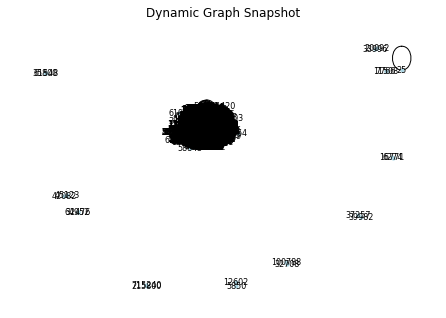

In [16]:
# Assuming dynamic_graph is a list of snapshots, and you want to visualize the first snapshot
snapshot_graph = dynamic_graph[0]

# Define a layout for the nodes (you can choose a layout that suits your data)
layout = nx.spring_layout(snapshot_graph)

# Draw the snapshot graph
nx.draw(snapshot_graph, layout, with_labels=True, node_size=10, font_size=8, node_color='lightblue')

# Add a title
plt.title("Dynamic Graph Snapshot")
plt.show()

#### Creating a graph representation using NetworkX

In [13]:
G = nx.Graph()

#### Define nodes based on unique src_bytes and dst_bytes values

In [ ]:
all_nodes = np.concatenate((df_encoded['src_bytes'].unique(), df_encoded['dst_bytes'].unique()))
G.add_nodes_from(all_nodes)

#### Define edges based on connections

In [ ]:
edges = [(row['src_bytes'], row['dst_bytes']) for _, row in df_encoded.iterrows()]
G.add_edges_from(edges)

#### calculating degree centrality 

In [ ]:
degree_centrality = nx.degree_centrality(G)
df_encoded['dg_src_bytes'] = df_encoded['src_bytes'].map(degree_centrality)
df_encoded['dg_dst_bytes'] = df_encoded['dst_bytes'].map(degree_centrality)

In [ ]:
df_encoded['dg_src_bytes']

### Model training

#### Spectral Clustering

In [ ]:
# Create a graph
G = nx.Graph()

# Calculate pairwise cosine similarity between data points
similarity_matrix = cosine_similarity(X)

# Add nodes to the graph
num_nodes = len(X_train[0:1000])
G.add_nodes_from(range(num_nodes))

# Add edges based on similarity threshold
similarity_threshold = 0.7  # Adjust as needed
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        similarity = similarity_matrix[i][j]
        if similarity > similarity_threshold:
            G.add_edge(i, j)

In [ ]:
for i in range(0, len(components)):
    print(i)
    if(i<(len(components)-1)):
        
        component1 = list(components[i])
        component2 = list(components[i+1])
        i=i+1

        # Add an edge between a random node in component1 and component2
        node1 = random.choice(component1)
        node2 = random.choice(component2)

        G.add_edge(node1, node2)
    else:
        if(nx.is_connected(G) == False):
            i = 0
        
components = list(nx.connected_components(G))

In [ ]:
# Visualize the clustered graph (optional)
# Here's a simple way to visualize the graph with nodes colored by cluster
pos = nx.spring_layout(G)
node_colors = [G.nodes[node]['cluster_label'] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.get_cmap('viridis'), with_labels=False)
plt.show()

In [ ]:
# Preprocess the data
# Convert the categorical features to numerical features
label_encoder = LabelEncoder()
for col in kdd99_data.columns:
    if kdd99_data[col].dtype == 'object':
        kdd99_data[col] = label_encoder.fit_transform(kdd99_data[col])

# Remove any outliers or missing values
kdd99_data = kdd99_data.dropna()

# Construct a dynamic graph from the data
# Use a sliding window approach to construct a sequence of graphs
window_size = 100
graphs = []
for i in range(0, len(kdd99_data) - window_size, window_size):
    graph = erdos_renyi_graph(kdd99_data.iloc[i:i + window_size, 0].unique().shape[0], 0.1)
    for j in range(1, window_size):
        graph.add_edges_from([
            (kdd99_data.iloc[i + j - 1, 0], kdd99_data.iloc[i + j, 0]),
            (kdd99_data.iloc[i + j, 0], kdd99_data.iloc[i + j - 1, 0])
        ])
    graphs.append(graph)

# Train a graph embedding model
# Use a GNN, such as GraphSAGE or GAT
# For this example, we will use GraphSAGE

from SAGE import GraphSAGE

graph_sage = GraphSAGE(graphs)
graph_sage.train()

# Train an anomaly detection model
# Use a variety of techniques, such as one-class classification, support vector machines, or isolation forests
# For this example, we will use a one-class SVM

from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM()
ocsvm.fit(graph_sage.embeddings)

# Evaluate the model
# Use a held-out test set to evaluate the model's performance on unseen data

# Split the data into a training set and a test set
X_train, X_test = train_test_split(graph_sage.embeddings, test_size=0.25)

# Make predictions on the test set
y_pred = ocsvm.predict(X_test)

# Calculate the accuracy
accuracy = np.sum(y_pred == 1) / len(y_pred)

# Print the accuracy
print('Accuracy:', accuracy)

In [7]:
class DySATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
        super(DySATModel, self).__init__()
        
        # Define DySAT layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(DySATConv(input_dim, hidden_dim, num_heads))
        
        # Linear layer for final classification
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, snapshot_graph):
        # Iterate through DySAT layers
        x = snapshot_graph.x  # Node features
        for conv in self.convs:
            x = conv(x, snapshot_graph.edge_index)
        
        # Final classification
        x = self.fc(x)
        return x

In [ ]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Initialize your DySAT model
model = DySATModel(input_dim, hidden_dim, num_heads, num_layers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function (e.g., cross-entropy)
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training data loader (you need to adapt this based on your data format)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for snapshot_graph in train_loader:
        snapshot_graph = snapshot_graph.to(device)
        
        # Forward pass
        logits = model(snapshot_graph)
        
        # Compute loss
        loss = criterion(logits, snapshot_graph.y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Print training loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

# Save the trained model (optional)
torch.save(model.state_dict(), "dysat_model.pth")